# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.905032,True,6.438227
1,0.140271,True,5.251128
2,0.277891,False,1.981748
3,0.678380,False,1.002011
4,-1.039772,False,-1.464319
...,...,...,...
995,-0.714020,False,-0.164058
996,3.048715,True,5.291997
997,1.113158,True,5.082386
998,-0.210727,False,-0.799048


<Axes: xlabel='v0'>

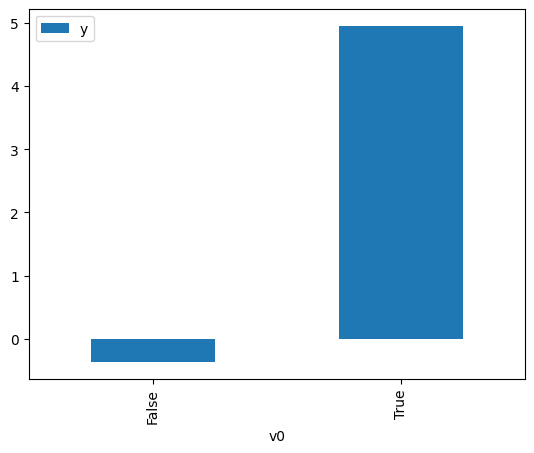

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

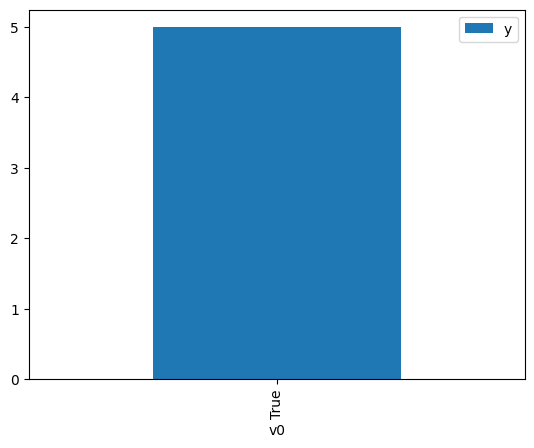

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.846785,False,1.031751,0.124170,8.053497
1,2.265146,False,-1.738571,0.005841,171.206906
2,0.625616,False,0.951308,0.188909,5.293542
3,0.252312,False,-0.255794,0.349955,2.857506
4,1.344199,False,1.333653,0.044363,22.541090
...,...,...,...,...,...
995,0.348403,False,0.333292,0.302608,3.304608
996,0.773374,False,-1.118118,0.143226,6.981982
997,0.307671,False,-2.455597,0.322242,3.103260
998,0.708735,False,0.998116,0.161966,6.174133


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,2.456185,True,6.373860,0.996188,1.003827
1,0.793988,True,4.194354,0.862359,1.159610
2,1.485103,True,6.038139,0.967271,1.033836
3,1.498700,True,4.164705,0.968224,1.032819
4,0.546667,True,4.322960,0.782435,1.278062
...,...,...,...,...,...
995,1.644665,True,4.392285,0.976896,1.023651
996,0.811862,True,5.023664,0.867052,1.153334
997,1.162726,True,6.031141,0.934786,1.069763
998,0.068547,True,5.720119,0.551511,1.813201


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              8206.
Date:                Thu, 21 Dec 2023   Prob (F-statistic):                        0.00
Time:                        15:57:27   Log-Likelihood:                         -1406.7
No. Observations:                1000   AIC:                                      2817.
Df Residuals:                     998   BIC:                                      2827.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1839      0.037      4.951      0.000       0.111       0.257
x2             4.9096      0.051     95.549      0.000       4.809       5.010
==============================================================================
Omnibus:                        0.406   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.816   Jarque-Bera (JB):                0.293
Skew:                           0.013   Prob(JB):                        0.864
Kurtosis:                       3.080   Cond. No.                         2.30
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""